# Churn Analysis

[Link to My Section](#my-section-title)

In [1]:
# Import Packages
import pandas as pd
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import seaborn as sns

import math
from datetime import datetime, timedelta

#import scikit-learn
#import jupyterlab
#import xgboost

# Set Display Preferences
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:.2f}".format

## DataPreparation
#datapreparation

### Load & remove duplicates

In [2]:
### UK Based ecom retailer sales from Jan 12, 2009 to Sep 12, 2011.
### Mainly sells unique all-occasion gift-ware.
df1 = pd.read_excel("data/online_retail_II.xlsx", sheet_name='Year 2009-2010', header=0)
df2 = pd.read_excel("data/online_retail_II.xlsx", sheet_name='Year 2010-2011', header=0)

### Note: Both excel sheets contain 2010 sales. Duplicates must be removed before concatenating.
# There is 1 week of overlap in the datasets
print(df1['InvoiceDate'].max())
print(df2['InvoiceDate'].min())

# Remove duplicate entries 
df1 = df1[~df1["Invoice"].isin(df2['Invoice'].unique())]
# Note: achives identical result as -> df1[df1['InvoiceDate']<df2['InvoiceDate'].min()] 

2010-12-09 20:01:00
2010-12-01 08:26:00


### Define new factors

In [3]:
### Merge the dataframes from each year
df = pd.concat([df1, df2], axis=0, ignore_index=True)

### Create a Invoice Amount column
df['Invoice Amount'] = df['Price'] * df['Quantity']

### Sales are overwhelmingly from the UK.
uk_pct = len(df[df['Country']=='United Kingdom']) / len(df)
print(f'Percent of entries sold in the UK: {uk_pct*100:.2f}%')
# Create a binary variable indicating UK vs. Global.
df['UK_Ind'] = np.where(df['Country']=='United Kingdom', 1, 0)

### Remove time component from Invoice Date
df['InvoiceDate'] = df['InvoiceDate'].dt.date

df_orig = df.copy()
df.head(10)

Percent of entries sold in the UK: 91.88%


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Invoice Amount,UK_Ind
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.00,United Kingdom,83.40,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.00,United Kingdom,81.00,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.00,United Kingdom,81.00,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.00,United Kingdom,100.80,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.00,United Kingdom,30.00,1
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01,1.65,13085.00,United Kingdom,39.60,1
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01,1.25,13085.00,United Kingdom,30.00,1
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01,5.95,13085.00,United Kingdom,59.50,1
8,489435,22350,CAT BOWL,12,2009-12-01,2.55,13085.00,United Kingdom,30.60,1
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01,3.75,13085.00,United Kingdom,45.00,1


### Remove null customer IDs & non-purchase invoice entries

In [4]:
### Null Customer IDs (required to determine churn). 
### Reason for missing Customer ID is unknown. For simplicity, these entries will be excluded from the analysis. This likely creates a source of bias.
### Recomendation is to update the ordering platform to require purchasers to create an account & generate a unique Customer ID.
null_id_pct = sum(df['Customer ID'].isnull()) / len(df)
print(f'Percent of entries that are missing Customer ID: {null_id_pct*100:.2f}%')


### Some items have a price of $0. These entries will not count towards orders.
### Primarily consisting of stickers, car flags, shipping materials & invoice notes.
non_items = len(df[df['Price']==0]) / len(df)
print(f'Percent of entries that had a price of $0: {non_items*100:.2f}%')


### Examining the Stock Codes, entries starting with alphabetic characters are atypical invoice entries that do not represent merchandise sales.
### Ex. Test products, adjustments, postage, carriage, etc.
df["StockCode"] = df["StockCode"].astype(str)
stockcode = (
    df.groupby(["StockCode", "Description"])["Quantity"]
      .sum()
      .reset_index()        
      .sort_values("StockCode", ascending=False)
    )

stockcode_pct = sum(~df['StockCode'].str.match(r'^\d')) / len(df)
print(f'Percent of entries that have invalid Stock Codes: {stockcode_pct*100:.2f}%')


### Remove entries is no Customer ID or Price = $0
df = df[~df['Customer ID'].isnull()]
df = df[df['Price']!=0]
### Remove entries for Stock Codes beginning with alphabetic characters
df = df[df['StockCode'].str.match(r'^\d')]

Percent of entries that are missing Customer ID: 22.52%
Percent of entries that had a price of $0: 0.58%
Percent of entries that have invalid Stock Codes: 0.57%


### Aggregate data to Customer ID granualrity

In [90]:
### Define aggragation function
def aggregate_by_cx(df):
    """
    Aggregate transaction data & group it by Customer ID
    """
    df = df.reset_index()
    df_aggregated = df.groupby(['Customer ID', 'UK_Ind'], as_index=False).agg(
        # First & last txn in the measurement period
        first_txn = ('InvoiceDate', 'min'),
        last_txn = ('InvoiceDate', 'max'),
        # Transaction Count
        total_txns = ('Invoice', 'nunique'),
        sale_txns = ('Invoice', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].nunique()),
        return_txns = ('Invoice', lambda x: x[df.loc[x.index, 'Quantity'] < 0].nunique()),
        # Sales amount ($)
        total_amt = ('Invoice Amount', 'sum'),
        sale_amt = ('Invoice Amount', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].sum()),
        return_amt = ('Invoice Amount', lambda x: x[df.loc[x.index, 'Quantity'] < 0].sum()),
        # Sale quantity
        total_qty = ('Quantity', 'sum'),
        sale_qty = ('Quantity', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].sum()),
        return_qty = ('Quantity', lambda x: x[df.loc[x.index, 'Quantity'] < 0].sum()),
        # Variaty of SKUs
        total_skus = ('StockCode', 'nunique'),
        sale_skus = ('StockCode', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].nunique()),
        # Frequency
        total_frequency = ('InvoiceDate', 'nunique'),
        sale_frequency = ('InvoiceDate', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].nunique())
        )

    # Returns Percent
    df_aggregated['return_pct'] = -1*df_aggregated['return_amt'] / (-1*df_aggregated['return_amt'] + df_aggregated['sale_amt'])
    # Units per Transaction
    df_aggregated['upt'] = df_aggregated['sale_qty'] / df_aggregated['sale_txns']
    # Average Unit Retail
    df_aggregated['aur'] = df_aggregated['sale_amt'] / df_aggregated['sale_qty']           ### Issues with div by 0 using total_qty
    # Average Order Value
    df_aggregated['aov'] = df_aggregated['sale_amt'] / df_aggregated['sale_txns']
    # SKU Mix per Order
    df_aggregated['sku_mix'] = df_aggregated['total_skus'] / df_aggregated['total_txns']
    
    return df_aggregated

In [91]:
### Check to confirm there are no Customer IDs found in multiple markets/countries
df_aggregated = aggregate_by_cx(df)
cx_market = df_aggregated.groupby("Customer ID")["UK_Ind"].count()
multi_market_cx = sum(cx_market>1)
print('Number of customers in multiple markets:', multi_market_cx)

Number of customers in multiple markets: 0


### Calculate Temporal factors

In [92]:
def calc_temporal_factors(df, n):
    """
    Takes dataframe, split by time windows, aggregate & calculate customer perchase data by period. Then calculate temporal factors (ex. streak/recency/churn).
    n = number of days per observation period.
    """
    ### Churn will be definited by if a customer purchases in the next N days.
    ### The past N days will be used to train a model that predicts likelihood to churn. This will be called the observation window.
    ### The dataset spans 2 years, so this approach evaluates churn using a recurant sliding window approach.
    observation_days = n
    observation_periods = (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days / observation_days
    observation_periods = int(math.floor(observation_periods))
    print('Number of', observation_days, 'day periods:', observation_periods, '\n')

    # Slice data by observation period starting from most recent & working backward by increments equal to the duration of the observation period
    end = df['InvoiceDate'].max()
    df_x = pd.DataFrame()
    for i in range(observation_periods):
        # Get start & end date for the given observation period.
        period_end = end
        period_start = period_end - timedelta(observation_days)
        # Create a temporary dataframe for the observation period. Aggregate by Customer ID & compute customer satistics.
        df_i = df[df['InvoiceDate'].between(period_start,period_end)]
        df_i = aggregate_by_cx(df_i)
        
        # Tag if customer churns in next period
        if i==0:
            churn_ind = np.nan
        else:
            churn_ind = df_i['Customer ID'].isin(df_next_period['Customer ID']).map({True: 0, False: 1})

        # Define new columns for Churn Indicator & Observation Period
        df_i.insert(loc=0, column='churn_ind', value=churn_ind)
        df_i.insert(loc=0, column='Period', value=observation_periods-i)
        df_i.insert(loc=0, column='Observation End', value=period_end)
        df_i.insert(loc=0, column='Observation Start', value=period_start)

        # Calculate recency from end of period to most recent trasnaction 
        df_i['Recency'] = end - df_i['last_txn']
        df_i['Recency'] = pd.to_timedelta(df_i['Recency'])
        df_i['Recency'] = df_i['Recency'].dt.days

        # Concatenate each period's customer data into a single dataframe
        df_x = pd.concat([df_x, df_i], ignore_index=True)

        # Updated end date for next period
        df_next_period = df_i.copy()
        end = period_start - timedelta(days=1)

    ### Calculate number of consecutive previous periods with purchase for each Customer ID
    df_x = df_x.sort_values(['Customer ID', 'Period'])
    # Detect start of streak
    df_x['streak_start'] = df_x.groupby('Customer ID')['Period'].diff().ne(1)
    # Assign streak ids
    df_x['streak_id'] = df_x.groupby('Customer ID')['streak_start'].cumsum()
    # Compute streak length within each streak group
    streak_length = df_x.groupby(['Customer ID','streak_id']).cumcount()
    df_x.insert(loc=3, column='streak_length', value=streak_length)
    df_x.drop(['streak_start', 'streak_id'], axis=1, inplace=True)

    # Sort data
    df_x = df_x.sort_values(by=['Customer ID', 'Observation Start'],ignore_index=True)

    # Remove final period as it is only used to define churn in period N-1
    df_x = df_x[df_x['Period']<observation_periods]
    df_x['churn_ind'] = df_x['churn_ind'].astype(int)
    
    return df_x

In [93]:
df_90 = calc_temporal_factors(df, 90)
df_90.head(10)

Number of 90 day periods: 8 



,Observation Start,Observation End,Period,streak_length,churn_ind,Customer ID,UK_Ind,first_txn,last_txn,total_txns,sale_txns,return_txns,total_amt,sale_amt,return_amt,total_qty,sale_qty,return_qty,total_skus,sale_skus,total_frequency,sale_frequency,return_pct,upt,aur,aov,sku_mix,Recency
0,2009-12-12,2010-03-12,1,0,1,12346.00,1,2010-03-02,2010-03-02,1,1,0,27.05,27.05,0.00,5,5,0,5,5,1,1,-0.00,5.00,5.41,27.05,5.00,10
1,2010-06-12,2010-09-10,3,0,1,12346.00,1,2010-06-28,2010-06-28,1,1,0,142.31,142.31,0.00,19,19,0,19,19,1,1,-0.00,19.00,7.49,142.31,19.00,74
2,2010-12-11,2011-03-11,5,0,1,12346.00,1,2011-01-18,2011-01-18,2,1,1,0.00,77183.60,-77183.60,0,74215,-74215,1,1,1,1,0.50,74215.00,1.04,77183.60,0.50,52
3,2010-09-11,2010-12-10,4,0,0,12347.00,0,2010-10-31,2010-12-07,2,2,0,1323.32,1323.32,0.00,828,828,0,70,70,2,2,-0.00,414.00,1.60,661.66,35.00,3
4,2010-12-11,2011-03-11,5,1,0,12347.00,0,2011-01-26,2011-01-26,1,1,0,475.39,475.39,0.00,315,315,0,29,29,1,1,-0.00,315.00,1.51,475.39,29.00,44
5,2011-03-12,2011-06-10,6,2,0,12347.00,0,2011-04-07,2011-06-09,2,2,0,1018.77,1018.77,0.00,679,679,0,39,39,2,2,-0.00,339.50,1.50,509.38,19.50,1
6,2011-06-11,2011-09-09,7,3,0,12347.00,0,2011-08-02,2011-08-02,1,1,0,584.91,584.91,0.00,277,277,0,22,22,1,1,-0.00,277.00,2.11,584.91,22.00,38
8,2010-09-11,2010-12-10,4,0,0,12348.00,0,2010-09-27,2010-09-27,1,1,0,221.16,221.16,0.00,372,372,0,19,19,1,1,-0.00,372.00,0.59,221.16,19.00,74
9,2010-12-11,2011-03-11,5,1,0,12348.00,0,2010-12-16,2011-01-25,2,2,0,840.24,840.24,0.00,1848,1848,0,17,17,2,2,-0.00,924.00,0.45,420.12,8.50,45
10,2011-03-12,2011-06-10,6,2,1,12348.00,0,2011-04-05,2011-04-05,1,1,0,327.00,327.00,0.00,268,268,0,4,4,1,1,-0.00,268.00,1.22,327.00,4.00,66


In [94]:
df_180 = calc_temporal_factors(df, 180)
df_180.head(10)

Number of 180 day periods: 4 



,Observation Start,Observation End,Period,streak_length,churn_ind,Customer ID,UK_Ind,first_txn,last_txn,total_txns,sale_txns,return_txns,total_amt,sale_amt,return_amt,total_qty,sale_qty,return_qty,total_skus,sale_skus,total_frequency,sale_frequency,return_pct,upt,aur,aov,sku_mix,Recency
0,2009-12-16,2010-06-14,1,0,0,12346.00,1,2010-03-02,2010-03-02,1,1,0,27.05,27.05,0.00,5,5,0,5,5,1,1,-0.00,5.00,5.41,27.05,5.00,104
1,2010-06-15,2010-12-12,2,1,0,12346.00,1,2010-06-28,2010-06-28,1,1,0,142.31,142.31,0.00,19,19,0,19,19,1,1,-0.00,19.00,7.49,142.31,19.00,167
2,2010-12-13,2011-06-11,3,2,1,12346.00,1,2011-01-18,2011-01-18,2,1,1,0.00,77183.60,-77183.60,0,74215,-74215,1,1,1,1,0.50,74215.00,1.04,77183.60,0.50,144
3,2010-06-15,2010-12-12,2,0,0,12347.00,0,2010-10-31,2010-12-07,2,2,0,1323.32,1323.32,0.00,828,828,0,70,70,2,2,-0.00,414.00,1.60,661.66,35.00,5
4,2010-12-13,2011-06-11,3,1,0,12347.00,0,2011-01-26,2011-06-09,3,3,0,1494.16,1494.16,0.00,994,994,0,58,58,3,3,-0.00,331.33,1.50,498.05,19.33,2
6,2010-06-15,2010-12-12,2,0,0,12348.00,0,2010-09-27,2010-09-27,1,1,0,221.16,221.16,0.00,372,372,0,19,19,1,1,-0.00,372.00,0.59,221.16,19.00,76
7,2010-12-13,2011-06-11,3,1,0,12348.00,0,2010-12-16,2011-04-05,3,3,0,1167.24,1167.24,0.00,2116,2116,0,21,21,3,3,-0.00,705.33,0.55,389.08,7.00,67
9,2009-12-16,2010-06-14,1,0,0,12349.00,0,2010-04-29,2010-04-29,1,1,0,1068.52,1068.52,0.00,473,473,0,46,46,1,1,-0.00,473.00,2.26,1068.52,46.00,46
10,2010-06-15,2010-12-12,2,1,1,12349.00,0,2010-10-28,2010-10-28,1,1,0,1152.62,1152.62,0.00,518,518,0,54,54,1,1,-0.00,518.00,2.23,1152.62,54.00,45
12,2010-12-13,2011-06-11,3,0,1,12350.00,0,2011-02-02,2011-02-02,1,1,0,294.40,294.40,0.00,196,196,0,16,16,1,1,-0.00,196.00,1.50,294.40,16.00,129


# Exploratory Data Analysis


## My Section Title

In [133]:
df_180.columns

Index(['Observation Start', 'Observation End', 'Period', 'streak_length',
       'churn_ind', 'Customer ID', 'UK_Ind', 'first_txn', 'last_txn',
       'total_txns', 'sale_txns', 'return_txns', 'total_amt', 'sale_amt',
       'return_amt', 'total_qty', 'sale_qty', 'return_qty', 'total_skus',
       'sale_skus', 'total_frequency', 'sale_frequency', 'return_pct', 'upt',
       'aur', 'aov', 'sku_mix', 'Recency', 'ln_total_txns', 'ln_upt', 'ln_aur',
       'ln_sku_mix'],
      dtype='object')

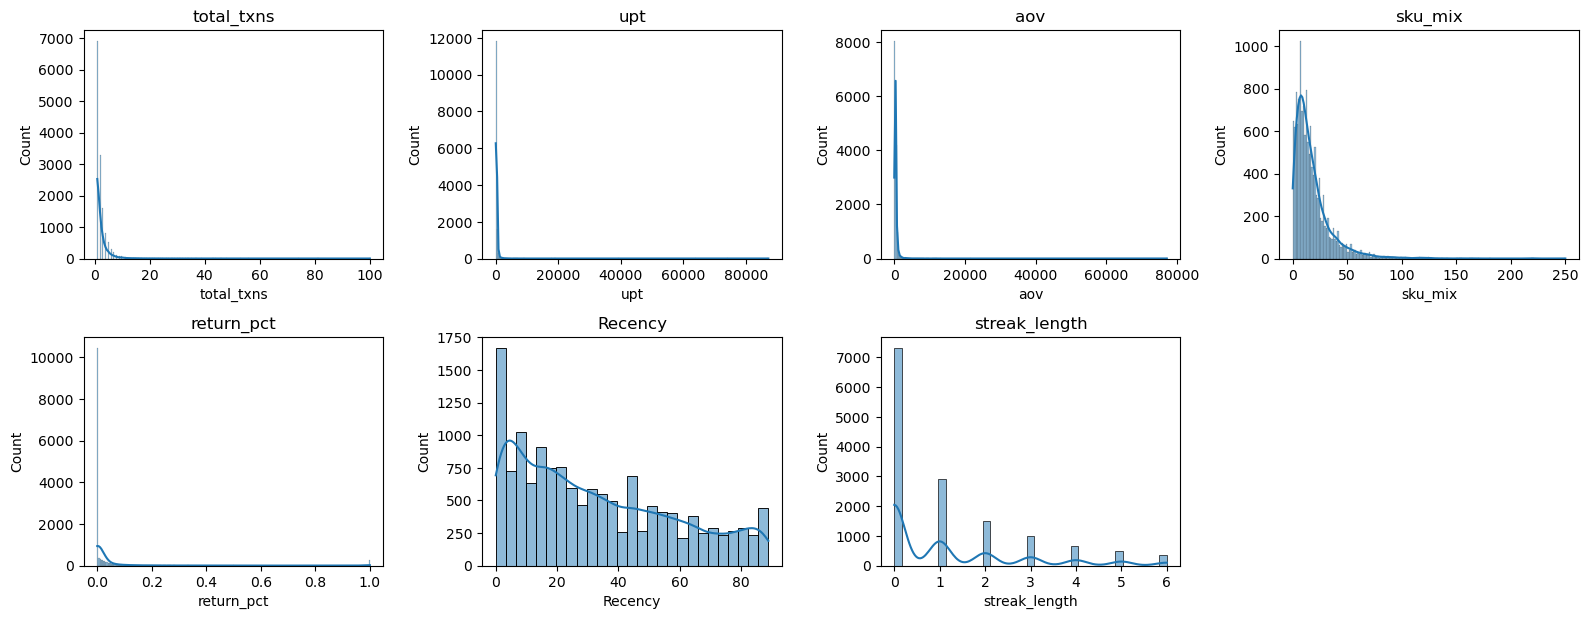

In [96]:
### Distribution of key variable
key_vars = ['total_txns', 'upt', 'aov', 'sku_mix', 'return_pct', 'Recency', 'streak_length']

plt.figure(figsize=(16, 12))
for i, col in enumerate(key_vars, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df_90[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

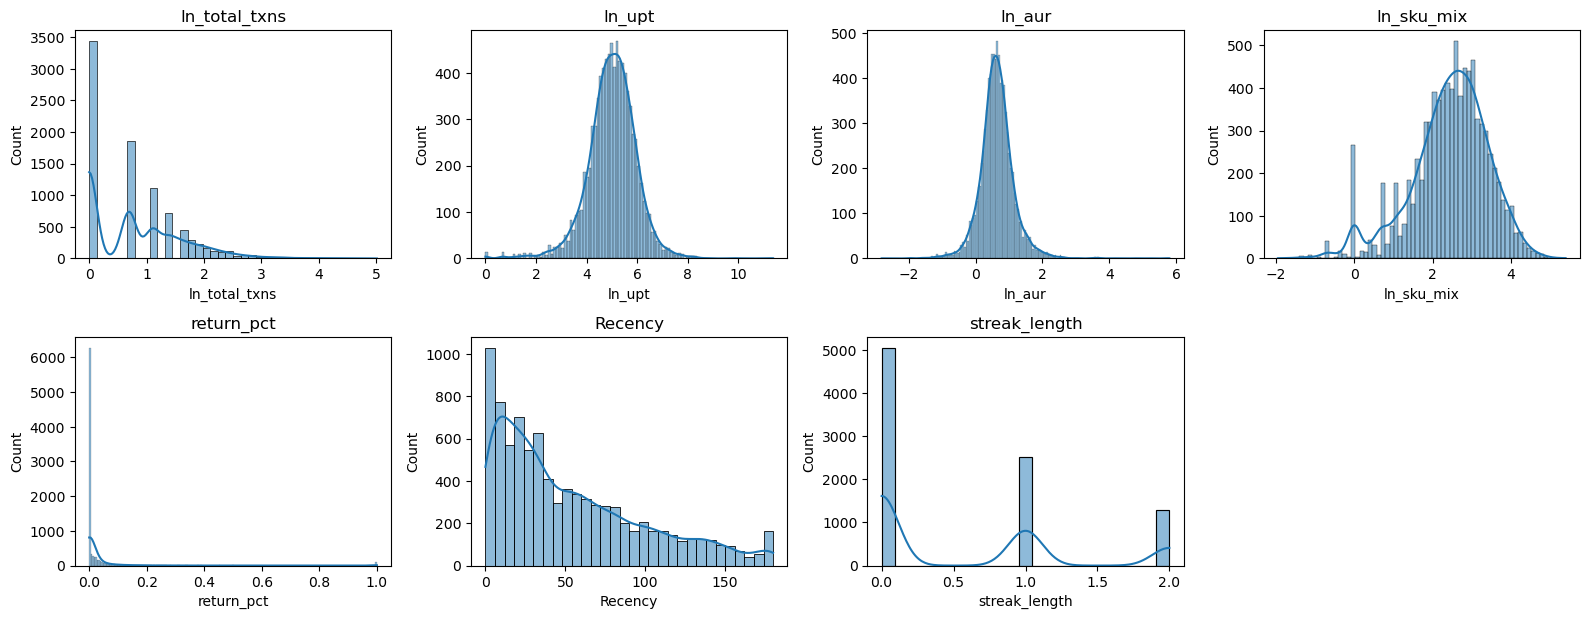

In [97]:
### Take natural log of continuous, skewed columns
cols = ['total_txns', 'upt', 'aur', 'sku_mix']
def log_cols(df, cols):
    """
    Take natural log of continuous, skewed columns.
    """
    for c in cols:
        df.loc[:, f"ln_{c}"] = np.log(df[c])
    return df

log_cols(df_90, cols)
log_cols(df_180, cols)


### Distribution of key variable
key_vars = ['ln_total_txns', 'ln_upt', 'ln_aur', 'ln_sku_mix', 'return_pct', 'Recency', 'streak_length']
plt.figure(figsize=(16, 12))
for i, col in enumerate(key_vars, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df_180[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

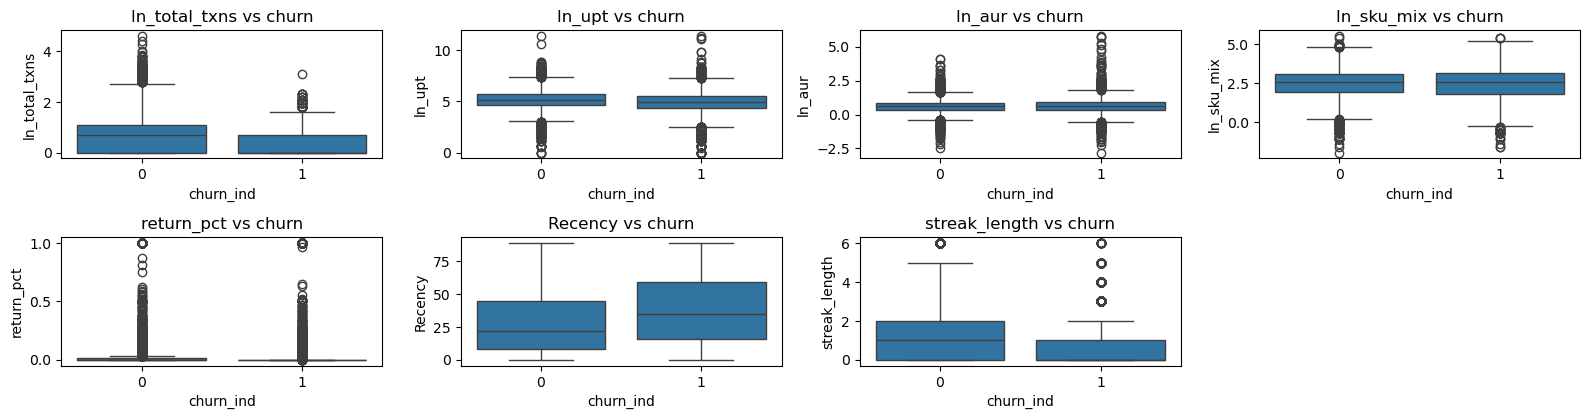

In [98]:
### Input replationships with churn
plt.figure(figsize=(16, 8))
for i, col in enumerate(key_vars, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x="churn_ind", y=col, data=df_90)
    plt.title(f"{col} vs churn")
plt.tight_layout()
plt.show()

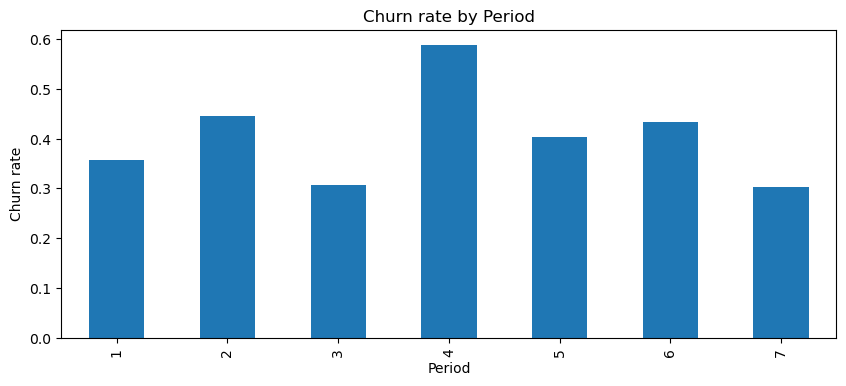

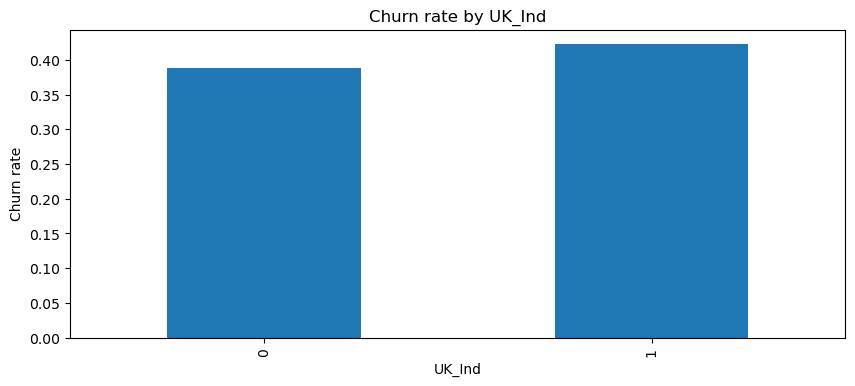

In [99]:
#df_180['Period'] = df_churn['df_180'].astype('category')
cat_vars = ["Period", "UK_Ind"]

for col in cat_vars:
    churn_rate = df_90.groupby(col)["churn_ind"].mean()
    churn_rate.plot(kind='bar', figsize=(10,4), title=f"Churn rate by {col}")
    plt.ylabel("Churn rate")
    plt.show()

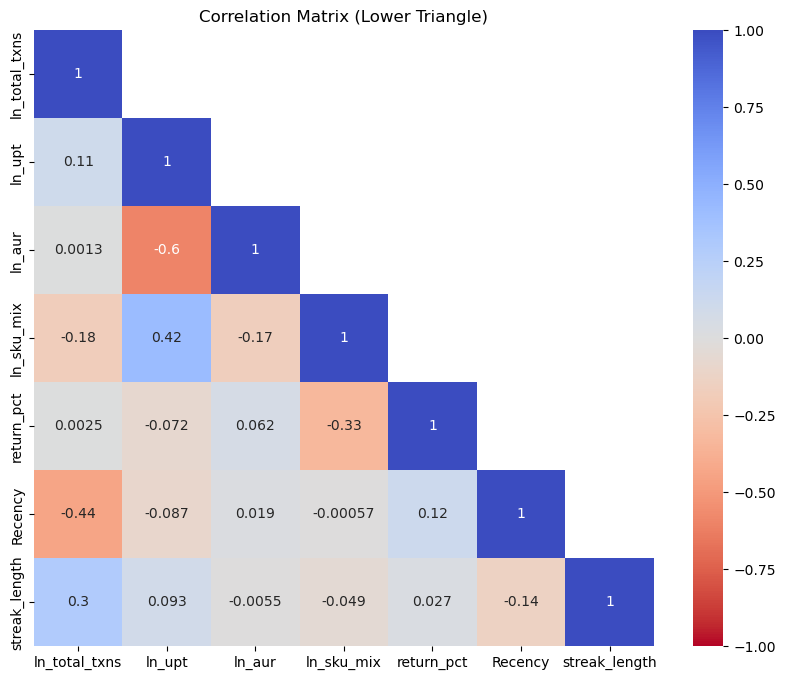

In [100]:
### Multicolinearity

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df_90[key_vars].corr(), dtype=bool), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(
    df_90[key_vars].corr(),
    mask=mask,
    annot=True,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Matrix (Lower Triangle)")
plt.show()

In [101]:
# Plot inputs against churn

In [102]:
### Outlier visualization

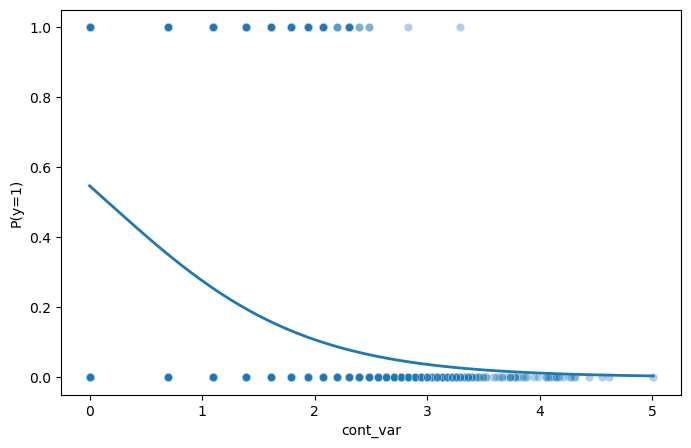

In [103]:
import statsmodels.api as sm

def plot_logistic_fit(x, y, xlabel="x", ylabel="y"):
    x = np.asarray(x)
    y = np.asarray(y)

    # Fit logistic regression (with intercept)
    X = sm.add_constant(x)
    model = sm.Logit(y, X).fit(disp=False)

    # Create smooth curve
    x_grid = np.linspace(x.min(), x.max(), 300)
    X_grid = sm.add_constant(x_grid)
    p_grid = model.predict(X_grid)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=x, y=y, alpha=0.35)  # jitter optional, see note below
    plt.plot(x_grid, p_grid, linewidth=2)

    plt.ylim(-0.05, 1.05)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    return model  # so you can inspect coefficients if you want

# Example:
plot_logistic_fit(df_180["ln_total_txns"], df_180["churn_ind"], xlabel="cont_var", ylabel="P(y=1)")


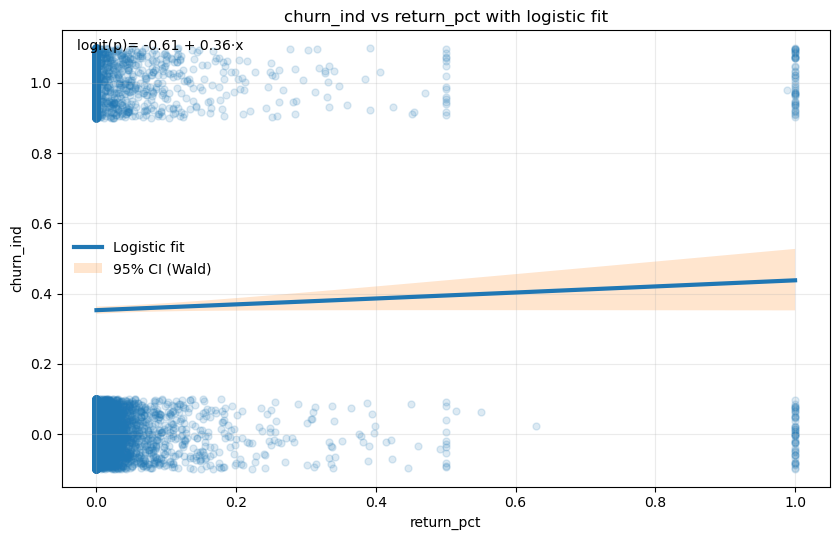

In [132]:

import statsmodels.api as sm

def plot_binary_logistic(df, x_col, y_col, n_grid=300, jitter=0.1, alpha=0.05):
     # Drop missing
    #d = df[[x_col, y_col]].dropna().copy()
    #x = d[x_col].astype(float).to_numpy()
    #y = d[y_col].astype(int).to_numpy()
    
    # Fit logistic regression
    X = sm.add_constant(df[x_col])
    model = sm.Logit(df[y_col], X).fit(disp=False)

    # Grid for smooth curve
    xg = np.linspace(df[x_col].min(), df[x_col].max(), n_grid)
    Xg = sm.add_constant(xg)

    # Predicted probabilities (mean curve)
    eta = Xg @ model.params
    p = 1 / (1 + np.exp(-eta))

    # 95% CI for mean curve using parameter covariance (Wald)
    cov = model.cov_params()                # 2x2 for [const, x]
    se_eta = np.sqrt(np.sum((Xg @ cov) * Xg, axis=1))  # diag(Xg*cov*Xg')
    z = 1.959963984540054                   # ~ norm.ppf(1 - alpha/2)

    lo = 1 / (1 + np.exp(-(eta - z * se_eta)))
    hi = 1 / (1 + np.exp(-(eta + z * se_eta)))

    # Jittered scatter for binary y
    rng = np.random.default_rng(0)
    yj = df[y_col] + rng.uniform(-jitter, jitter, size=len(df[y_col]))

    # Plot
    fig, ax = plt.subplots(figsize=(8.5, 5.5))
    ax.scatter(df[x_col], yj, alpha=0.15, s=25)
    ax.plot(xg, p, linewidth=3, label="Logistic fit")
    ax.fill_between(xg, lo, hi, alpha=0.2, label="95% CI (Wald)")

    ax.set_ylim(-0.15, 1.15)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{y_col} vs {x_col} with logistic fit")
    ax.grid(True, alpha=0.25)
    ax.legend(frameon=False)

    b0, b1 = model.params
    ax.text(0.02, 0.98, f"logit(p)= {b0:.2f} + {b1:.2f}·x",
            transform=ax.transAxes, va="top")

    plt.tight_layout()
    plt.show()

    return model

# usage:
plot_binary_logistic(df_180, x_col="return_pct", y_col="churn_ind")

In [126]:
plot_binary_logistic(df_180, x_col="ln_upt", y_col="churn_ind")

MissingDataError: exog contains inf or nans

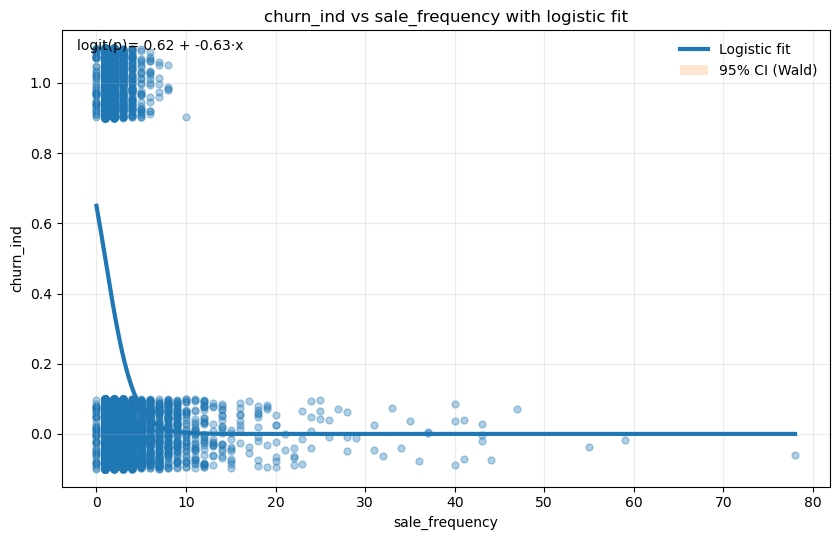

In [127]:
plot_binary_logistic(df_180, x_col="sale_frequency", y_col="churn_ind")

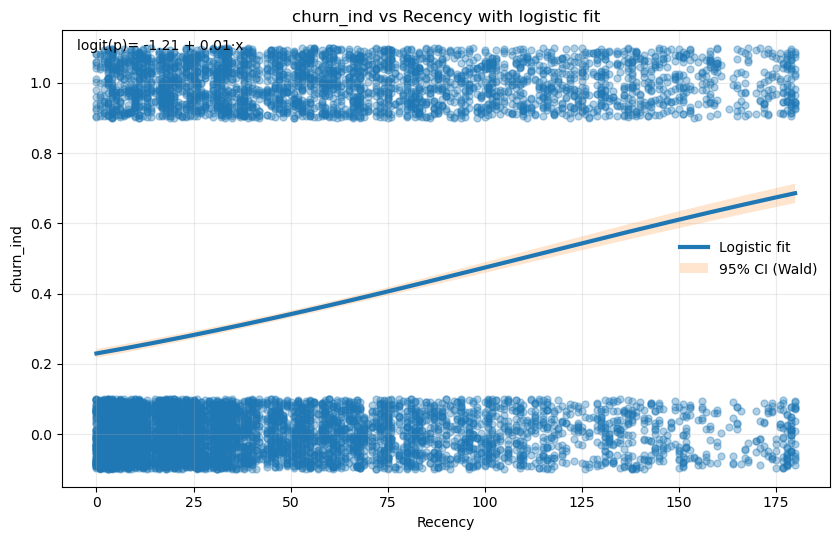

In [129]:
plot_binary_logistic(df_180, x_col="Recency", y_col="churn_ind")

In [19]:
df_180

,Observation Start,Observation End,Period,streak_length,churn_ind,Customer ID,UK_Ind,first_txn,last_txn,total_txns,sale_txns,return_txns,total_amt,sale_amt,return_amt,total_qty,sale_qty,return_qty,total_skus,sale_skus,return_pct,upt,aur,aov,sku_mix,Recency,ln_total_txns,ln_upt,ln_aur,ln_sku_mix
0,2009-12-16,2010-06-14,1,0,0.00,12346.00,1,2010-03-02,2010-03-02,1,1,0,27.05,27.05,0.00,5,5,0,5,5,-0.00,5.00,5.41,27.05,5.00,104,0.00,1.61,1.69,1.61
1,2010-06-15,2010-12-12,2,1,0.00,12346.00,1,2010-06-28,2010-06-28,1,1,0,142.31,142.31,0.00,19,19,0,19,19,-0.00,19.00,7.49,142.31,19.00,167,0.00,2.94,2.01,2.94
2,2010-12-13,2011-06-11,3,2,1.00,12346.00,1,2011-01-18,2011-01-18,2,1,1,0.00,77183.60,-77183.60,0,74215,-74215,1,1,0.50,74215.00,1.04,77183.60,0.50,144,0.69,11.21,0.04,-0.69
3,2010-06-15,2010-12-12,2,0,0.00,12347.00,0,2010-10-31,2010-12-07,2,2,0,1323.32,1323.32,0.00,828,828,0,70,70,-0.00,414.00,1.60,661.66,35.00,5,0.69,6.03,0.47,3.56
4,2010-12-13,2011-06-11,3,1,0.00,12347.00,0,2011-01-26,2011-06-09,3,3,0,1494.16,1494.16,0.00,994,994,0,58,58,-0.00,331.33,1.50,498.05,19.33,2,1.10,5.80,0.41,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12346,2009-12-16,2010-06-14,1,0,0.00,18286.00,1,2009-12-16,2009-12-16,1,1,0,412.95,412.95,0.00,113,113,0,16,16,-0.00,113.00,3.65,412.95,16.00,180,0.00,4.73,1.30,2.77
12347,2010-06-15,2010-12-12,2,1,1.00,18286.00,1,2010-06-24,2010-08-20,2,1,1,725.48,833.48,-108.00,478,494,-16,53,50,0.11,494.00,1.69,833.48,26.50,114,0.69,6.20,0.52,3.28
12348,2009-12-16,2010-06-14,1,0,0.00,18287.00,1,2010-05-17,2010-05-17,1,1,0,1071.61,1071.61,0.00,732,732,0,54,54,-0.00,732.00,1.46,1071.61,54.00,28,0.00,6.60,0.38,3.99
12349,2010-06-15,2010-12-12,2,1,0.00,18287.00,1,2010-09-21,2010-11-22,3,3,0,1224.10,1224.10,0.00,694,694,0,28,28,-0.00,231.33,1.76,408.03,9.33,20,1.10,5.44,0.57,2.23


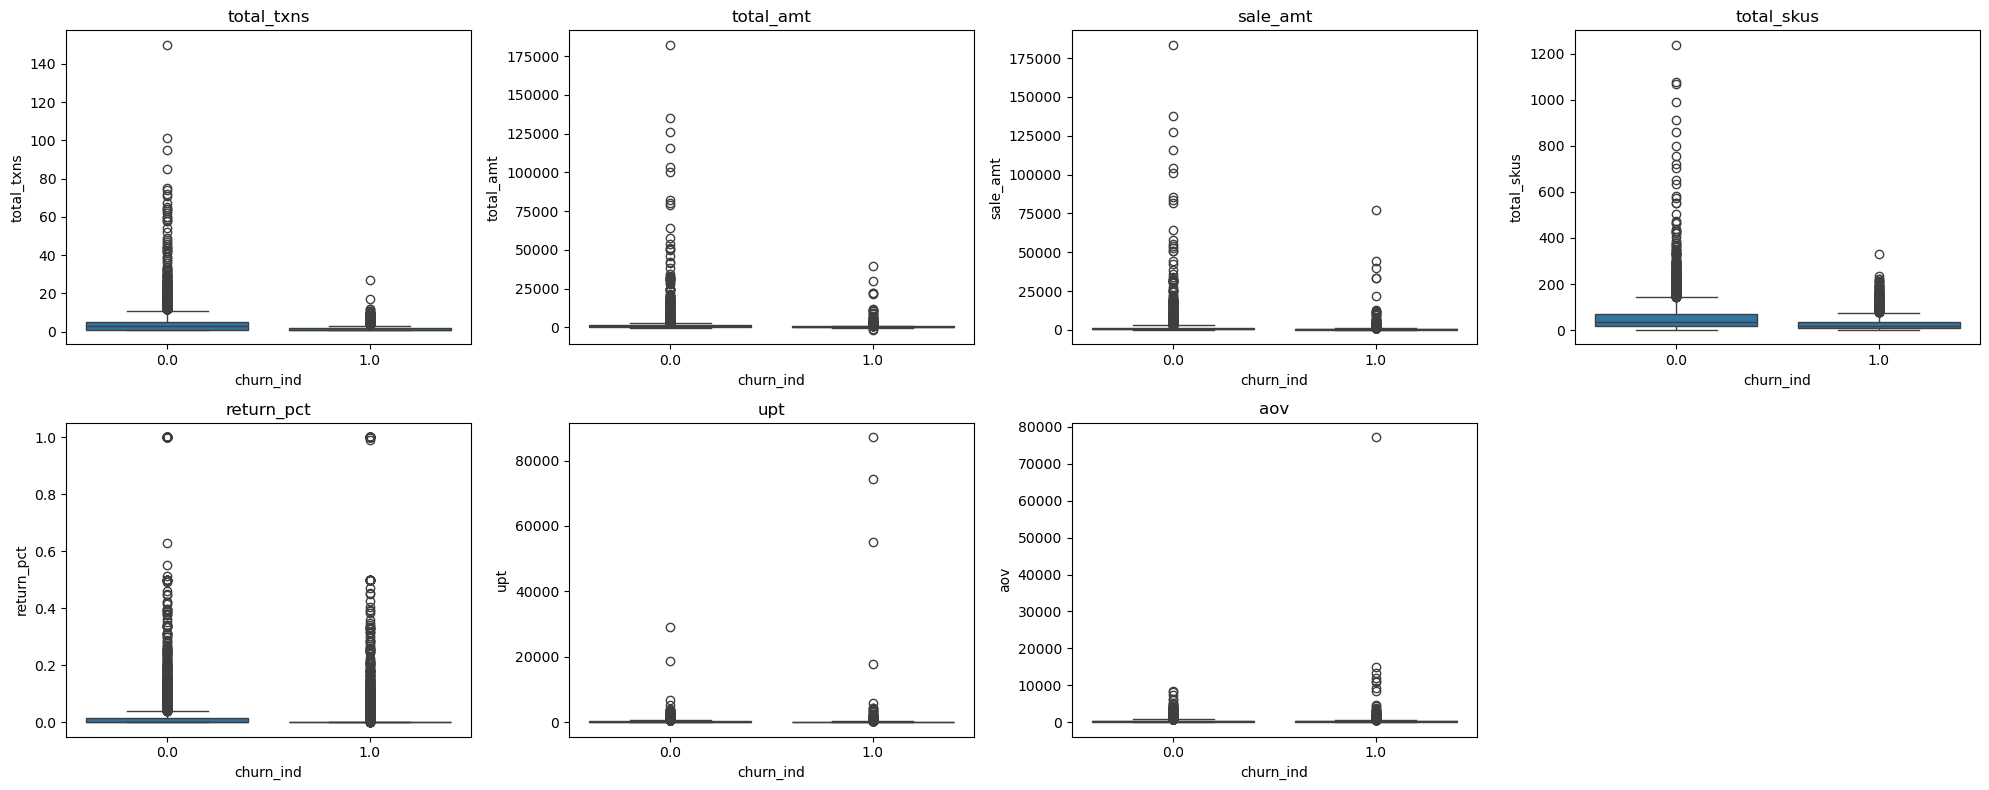

In [20]:
import seaborn as sns

df_churn = df_180[df_180['Period']!=4]

target = "churn_ind"

features = ['total_txns', 'total_amt', 'sale_amt', 'total_skus', 'return_pct', 'upt', 'aov']

# compute grid size automatically
n = len(features)
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df_churn[target], y=df_churn[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## Model Results

In [21]:
#35% churn 180 days

#42% churn 90 days
df_180.columns

Index(['Observation Start', 'Observation End', 'Period', 'streak_length',
       'churn_ind', 'Customer ID', 'UK_Ind', 'first_txn', 'last_txn',
       'total_txns', 'sale_txns', 'return_txns', 'total_amt', 'sale_amt',
       'return_amt', 'total_qty', 'sale_qty', 'return_qty', 'total_skus',
       'sale_skus', 'return_pct', 'upt', 'aur', 'aov', 'sku_mix', 'Recency',
       'ln_total_txns', 'ln_upt', 'ln_aur', 'ln_sku_mix'],
      dtype='object')

In [22]:
dft = df_churn.copy()
#dft.drop(['aur', 'aov', 'return_pct', 'upt'], axis=1, inplace=True)




# Keep only rows where churn is defined (Periods 1–3) 
dft = dft[dft['Period'] <= dft['Period'].max()]

# Train = Periods 1 and 2
train_df = dft[dft['Period'] < dft['Period'].max()].copy()

# Test = Period 3 (most recent labeled period)
test_df = dft[dft['Period'] == dft['Period'].max()].copy()


# Clean target leakage
drop_cols = [
    'Observation Start', 'Observation End',
    'Period', 'Customer ID',
    'first_txn', 'last_txn'
]

X_train = train_df.drop(columns=drop_cols + ['churn_ind'])
y_train = train_df['churn_ind']

X_test = test_df.drop(columns=drop_cols + ['churn_ind'])
y_test = test_df['churn_ind']

# Fill missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Scale for Logistic Regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## fit logistic regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]


## Fit gradiant boost
from xgboost import XGBClassifier

gb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]


period_length = (dft[dft['Period'] == dft['Period'].min()]['Observation End'][0] - dft[dft['Period'] == dft['Period'].min()]['Observation Start'][0]).days

## evaluate both
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(y_true, y_pred, y_prob, model_name):
    print(f"\n=== {model_name} : {period_length} days ===")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_true, y_prob):.4f}")

evaluate(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
evaluate(y_test, y_pred_gb, y_prob_gb, "Gradient Boosting (XGBoost)")


=== Logistic Regression : 180 days ===
Accuracy : 0.6557
Precision: 0.4387
Recall   : 0.6787
F1 Score : 0.5329
ROC-AUC  : 0.7022

=== Gradient Boosting (XGBoost) : 180 days ===
Accuracy : 0.6699
Precision: 0.4507
Recall   : 0.6426
F1 Score : 0.5298
ROC-AUC  : 0.7213


### Comparing model results

### Interpreting SHAP values

In [23]:
dft['Period'].min()

np.int64(1)

### Customer Segmentation